# Experiments on DP-SGD with Ocapus

The experiments are based on the tutorial: [Building an Image Classifier with Differential Privacy](https://opacus.ai/tutorials/building_image_classifier).

To get started:

In [ ]:
!pip install opacus

In [ ]:
# config.py
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DELTA = 1e-5

LR = 1e-3
EPOCHS = 20
BATCH_SIZE = 512
MAX_PHYSICAL_BATCH_SIZE = 128


In [ ]:
# data.py
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10

# These values, specific to the CIFAR10 dataset, are assumed to be known.
# If necessary, they can be computed with modest privacy budgets.

def load_data():
    CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
    CIFAR10_STD_DEV = (0.2023, 0.1994, 0.2010)

    BATCH_SIZE = 512
    MAX_PHYSICAL_BATCH_SIZE = 128

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD_DEV),
    ])

    DATA_ROOT = '../cifar10'

    train_dataset = CIFAR10(
        root=DATA_ROOT, train=True, download=True, transform=transform)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
    )

    test_dataset = CIFAR10(
        root=DATA_ROOT, train=False, download=True, transform=transform)

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
    )
    return train_loader, test_loader

# train_loader, test_loader = load_data()

In [ ]:
# model.py
from torchvision import models
from opacus.validators import ModuleValidator

def load_model():
    model = models.resnet18(num_classes=10)

    # Check if the model is compatible with the privacy engine
    model = ModuleValidator.fix(model)
    ModuleValidator.validate(model, strict=False)

    # Transfer the neural network onto that device
    model = model.to(device)
    return model

# model = load_model()

In [ ]:
# utils.py
import matplotlib.pyplot as plt

class ExperimentLogger:
    def log(self, values):
        for k, v in values.items():
            if k not in self.__dict__:
                self.__dict__[k] = [v]
            else:
                self.__dict__[k] += [v]

def display_train_stats(cfl_stats, title = "", target_accuracy=0.5):
    # clear_output(wait=True)
    num_epochs = max(cfl_stats.epoch)

    fig = plt.figure(figsize=(10,3))
    plt.title(title)

    plt.subplot(1,3,1)

    plt.plot(cfl_stats.epoch, cfl_stats.top1_acc, color="C0")

    plt.axhline(y=target_accuracy, linestyle="--", color="r")
    plt.legend()

    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy")

    plt.xlim(0, num_epochs)
    plt.ylim(0,1)

    plt.subplot(1,3,2)

    plt.plot(cfl_stats.epoch, cfl_stats.loss, color="C1", label=r"Training Loss")

    plt.xlabel("Training Epochs")
    plt.legend()

    plt.xlim(0, num_epochs)
    plt.ylim(0, 2)

    plt.subplot(1,3,3)

    plt.plot(cfl_stats.epoch, cfl_stats.epsilon, color="C2", label=r"Privacy")

    plt.xlabel("Training Epochs")
    plt.legend()

    plt.xlim(0, num_epochs)
    plt.ylim(0, 2)


    return fig

In [ ]:
# train.py
import numpy as np
from opacus import PrivacyEngine
from opacus.utils.batch_memory_manager import BatchMemoryManager

def accuracy(preds, labels):
    return (preds == labels).mean()

def train_one_epoch(model, optimizer, train_loader, current_epoch, target_epsilon, max_grad_norm, device):

    model.train()
    criterion = nn.CrossEntropyLoss()

    losses = []
    top1_acc = []

    with BatchMemoryManager(
        data_loader=train_loader,
        max_physical_batch_size=MAX_PHYSICAL_BATCH_SIZE,
        optimizer=optimizer
    ) as memory_safe_data_loader:

        for i, (images, target) in enumerate(memory_safe_data_loader):
            optimizer.zero_grad()
            images = images.to(device)
            target = target.to(device)

            # compute output
            output = model(images)
            loss = criterion(output, target)

            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            labels = target.detach().cpu().numpy()

            # measure accuracy and record loss
            acc = accuracy(preds, labels)
            epsilon = None

            losses.append(loss.item())
            top1_acc.append(acc)

            loss.backward()
            optimizer.step()

            if (i+1) % 400 == 0:
                epsilon = privacy_engine.get_epsilon(DELTA)
                print(
                    f"\tTrain Epoch: {current_epoch} \t"
                    f"Loss: {np.mean(losses):.6f} "
                    f"Acc@1: {np.mean(top1_acc):.6f} "
                    f"(ε = {epsilon:.2f}, δ = {DELTA})"
                )

    return np.mean(losses), np.mean(top1_acc), epsilon

def train(model, optimizer, train_loader, num_epoch, target_epsilon, max_grad_norm, device):
    cfl_stats = ExperimentLogger()
    for epoch in range(num_epoch):
        loss, top1_acc, epsilon = train_one_epoch(model, optimizer, train_loader, epoch+1, target_epsilon, max_grad_norm, device)
        cfl_stats.log({"epoch":epoch, "loss":loss, "top1_acc":top1_acc, "epsilon":epsilon})
    fig = display_train_stats(cfl_stats, title=f'EPS={target_epsilon}, C={max_grad_norm}', target_accuracy=0.50)

    return cfl_stats

def test(model, test_loader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    losses = []
    top1_acc = []

    with torch.no_grad():
        for images, target in test_loader:
            images = images.to(device)
            target = target.to(device)

            output = model(images)
            loss = criterion(output, target)
            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            labels = target.detach().cpu().numpy()
            acc = accuracy(preds, labels)

            losses.append(loss.item())
            top1_acc.append(acc)

    top1_avg = np.mean(top1_acc)

    print(
        f"\tTest set:"
        f"Loss: {np.mean(losses):.6f} "
        f"Acc: {top1_avg * 100:.6f} "
    )
    return np.mean(top1_acc)

Files already downloaded and verified
Files already downloaded and verified
=====EPS=5=====
Using sigma=0.7598876953125 and C=1.0
	Train Epoch: 1 	Loss: 2.247082 Acc@1: 0.250324 (ε = 1.79, δ = 1e-05)
	Train Epoch: 2 	Loss: 1.743709 Acc@1: 0.391934 (ε = 2.14, δ = 1e-05)
	Train Epoch: 3 	Loss: 1.705339 Acc@1: 0.431775 (ε = 2.39, δ = 1e-05)
	Train Epoch: 4 	Loss: 1.717059 Acc@1: 0.459525 (ε = 2.62, δ = 1e-05)
	Train Epoch: 5 	Loss: 1.723005 Acc@1: 0.475724 (ε = 2.82, δ = 1e-05)
	Train Epoch: 6 	Loss: 1.726802 Acc@1: 0.487737 (ε = 3.01, δ = 1e-05)
	Train Epoch: 7 	Loss: 1.724569 Acc@1: 0.498338 (ε = 3.19, δ = 1e-05)
	Train Epoch: 8 	Loss: 1.726013 Acc@1: 0.506306 (ε = 3.36, δ = 1e-05)
	Train Epoch: 9 	Loss: 1.723168 Acc@1: 0.510529 (ε = 3.51, δ = 1e-05)
	Train Epoch: 10 	Loss: 1.711710 Acc@1: 0.521470 (ε = 3.67, δ = 1e-05)
	Train Epoch: 11 	Loss: 1.706968 Acc@1: 0.528312 (ε = 3.82, δ = 1e-05)
	Train Epoch: 12 	Loss: 1.698222 Acc@1: 0.532881 (ε = 3.96, δ = 1e-05)
	Train Epoch: 13 	Loss: 1.6

=====EPS=10=====
Using sigma=0.601348876953125 and C=1.0
	Train Epoch: 1 	Loss: 2.344266 Acc@1: 0.222452 (ε = 3.76, δ = 1e-05)
	Train Epoch: 2 	Loss: 1.747420 Acc@1: 0.393099 (ε = 4.43, δ = 1e-05)
	Train Epoch: 3 	Loss: 1.720061 Acc@1: 0.439017 (ε = 4.93, δ = 1e-05)
	Train Epoch: 4 	Loss: 1.718455 Acc@1: 0.470574 (ε = 5.39, δ = 1e-05)
	Train Epoch: 5 	Loss: 1.733433 Acc@1: 0.489096 (ε = 5.79, δ = 1e-05)
	Train Epoch: 6 	Loss: 1.722788 Acc@1: 0.503913 (ε = 6.16, δ = 1e-05)
	Train Epoch: 7 	Loss: 1.725865 Acc@1: 0.514786 (ε = 6.50, δ = 1e-05)
	Train Epoch: 8 	Loss: 1.693441 Acc@1: 0.528770 (ε = 6.83, δ = 1e-05)
	Train Epoch: 9 	Loss: 1.710642 Acc@1: 0.532235 (ε = 7.14, δ = 1e-05)
	Train Epoch: 10 	Loss: 1.691733 Acc@1: 0.542214 (ε = 7.44, δ = 1e-05)
	Train Epoch: 11 	Loss: 1.691175 Acc@1: 0.549750 (ε = 7.73, δ = 1e-05)
	Train Epoch: 12 	Loss: 1.684646 Acc@1: 0.554810 (ε = 8.00, δ = 1e-05)
	Train Epoch: 13 	Loss: 1.698986 Acc@1: 0.554112 (ε = 8.27, δ = 1e-05)
	Train Epoch: 14 	Loss: 1.666

=====EPS=50=====
Using sigma=0.37197113037109375 and C=1.0
	Train Epoch: 1 	Loss: 2.377956 Acc@1: 0.217335 (ε = 14.73, δ = 1e-05)
	Train Epoch: 2 	Loss: 1.721266 Acc@1: 0.415558 (ε = 18.37, δ = 1e-05)
	Train Epoch: 3 	Loss: 1.730061 Acc@1: 0.476779 (ε = 21.21, δ = 1e-05)
	Train Epoch: 4 	Loss: 1.746542 Acc@1: 0.500806 (ε = 23.73, δ = 1e-05)
	Train Epoch: 5 	Loss: 1.710156 Acc@1: 0.527888 (ε = 25.89, δ = 1e-05)
	Train Epoch: 6 	Loss: 1.734196 Acc@1: 0.540141 (ε = 27.99, δ = 1e-05)
	Train Epoch: 7 	Loss: 1.691762 Acc@1: 0.559874 (ε = 29.93, δ = 1e-05)
	Train Epoch: 8 	Loss: 1.698082 Acc@1: 0.567827 (ε = 31.78, δ = 1e-05)
	Train Epoch: 9 	Loss: 1.688775 Acc@1: 0.577169 (ε = 33.50, δ = 1e-05)
	Train Epoch: 10 	Loss: 1.688370 Acc@1: 0.583617 (ε = 35.20, δ = 1e-05)
	Train Epoch: 11 	Loss: 1.653547 Acc@1: 0.593946 (ε = 36.85, δ = 1e-05)
	Train Epoch: 12 	Loss: 1.626973 Acc@1: 0.603900 (ε = 38.42, δ = 1e-05)
	Train Epoch: 13 	Loss: 1.632315 Acc@1: 0.608258 (ε = 39.97, δ = 1e-05)
	Train Epoch: 

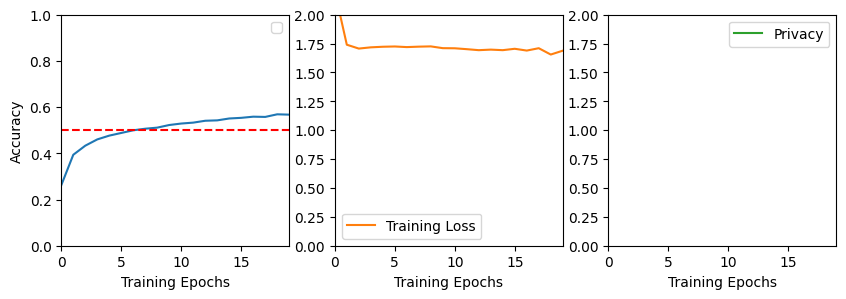

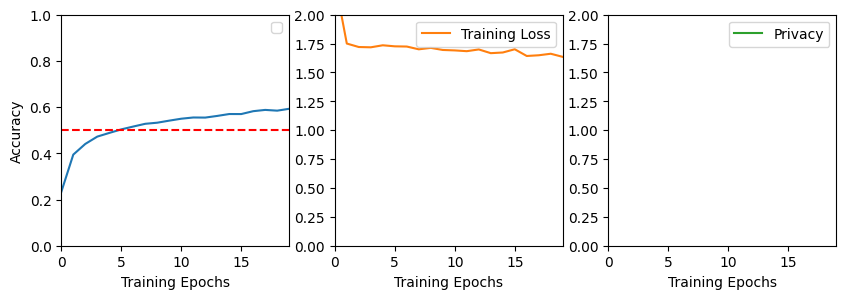

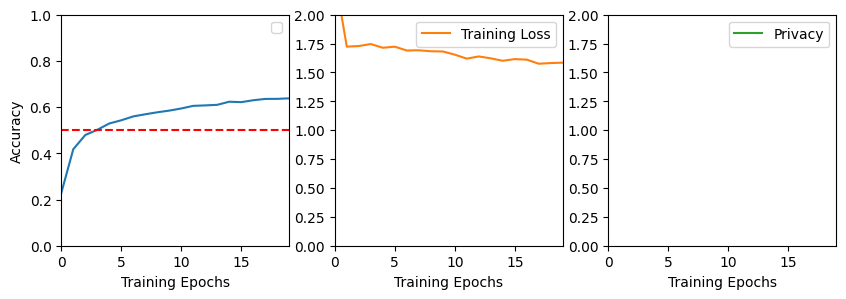

In [ ]:
# main.py
import warnings
warnings.simplefilter("ignore")

import torch.nn as nn
import torch.optim as optim

train_loader, test_loader = load_data()
C = 1.0


for eps in [5, 10, 50][:]:
    print(f'=====EPS={eps}=====')
    model = load_model()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.RMSprop(model.parameters(), lr=LR)
    privacy_engine = PrivacyEngine()

    model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
        module=model,
        optimizer=optimizer,
        data_loader=train_loader,
        epochs=EPOCHS,
        target_epsilon=eps,
        target_delta=DELTA,
        max_grad_norm=C,
    )

    print(f"Using sigma={optimizer.noise_multiplier} and C={C}")

    cfl_stats = train(model, optimizer, train_loader, EPOCHS, eps, C, device)

=====C=1=====
	Train Epoch: 1 	Loss: 2.299514 Acc@1: 0.231248 (ε = 3.77, δ = 1e-05)
	Train Epoch: 2 	Loss: 1.715080 Acc@1: 0.407530 (ε = 4.42, δ = 1e-05)
	Train Epoch: 3 	Loss: 1.708193 Acc@1: 0.456894 (ε = 4.94, δ = 1e-05)
	Train Epoch: 4 	Loss: 1.733225 Acc@1: 0.479933 (ε = 5.39, δ = 1e-05)
	Train Epoch: 5 	Loss: 1.729445 Acc@1: 0.498077 (ε = 5.79, δ = 1e-05)
	Train Epoch: 6 	Loss: 1.725457 Acc@1: 0.513640 (ε = 6.16, δ = 1e-05)
	Train Epoch: 7 	Loss: 1.739559 Acc@1: 0.520065 (ε = 6.50, δ = 1e-05)
	Train Epoch: 8 	Loss: 1.701483 Acc@1: 0.536044 (ε = 6.83, δ = 1e-05)
	Train Epoch: 9 	Loss: 1.695889 Acc@1: 0.543276 (ε = 7.14, δ = 1e-05)
	Train Epoch: 10 	Loss: 1.682660 Acc@1: 0.549702 (ε = 7.44, δ = 1e-05)
	Train Epoch: 11 	Loss: 1.672490 Acc@1: 0.559636 (ε = 7.73, δ = 1e-05)
	Train Epoch: 12 	Loss: 1.698107 Acc@1: 0.554390 (ε = 7.99, δ = 1e-05)
	Train Epoch: 13 	Loss: 1.693470 Acc@1: 0.562432 (ε = 8.27, δ = 1e-05)
	Train Epoch: 14 	Loss: 1.667166 Acc@1: 0.568651 (ε = 8.53, δ = 1e-05)
	

=====C=5=====
	Train Epoch: 1 	Loss: 2.345804 Acc@1: 0.219589 (ε = 3.76, δ = 1e-05)
	Train Epoch: 2 	Loss: 1.707148 Acc@1: 0.404502 (ε = 4.42, δ = 1e-05)
	Train Epoch: 3 	Loss: 1.648570 Acc@1: 0.452810 (ε = 4.95, δ = 1e-05)
	Train Epoch: 4 	Loss: 1.632147 Acc@1: 0.477873 (ε = 5.39, δ = 1e-05)
	Train Epoch: 5 	Loss: 1.615818 Acc@1: 0.495528 (ε = 5.79, δ = 1e-05)
	Train Epoch: 6 	Loss: 1.600280 Acc@1: 0.508044 (ε = 6.16, δ = 1e-05)
	Train Epoch: 7 	Loss: 1.574136 Acc@1: 0.521967 (ε = 6.50, δ = 1e-05)
	Train Epoch: 8 	Loss: 1.572796 Acc@1: 0.532137 (ε = 6.83, δ = 1e-05)
	Train Epoch: 9 	Loss: 1.584606 Acc@1: 0.535474 (ε = 7.14, δ = 1e-05)
	Train Epoch: 10 	Loss: 1.544680 Acc@1: 0.546626 (ε = 7.44, δ = 1e-05)
	Train Epoch: 11 	Loss: 1.547188 Acc@1: 0.553370 (ε = 7.72, δ = 1e-05)
	Train Epoch: 12 	Loss: 1.560677 Acc@1: 0.555075 (ε = 7.99, δ = 1e-05)
	Train Epoch: 13 	Loss: 1.526280 Acc@1: 0.562415 (ε = 8.27, δ = 1e-05)
	Train Epoch: 14 	Loss: 1.538017 Acc@1: 0.562225 (ε = 8.53, δ = 1e-05)
	

=====C=10=====
	Train Epoch: 1 	Loss: 2.316524 Acc@1: 0.238617 (ε = 3.77, δ = 1e-05)
	Train Epoch: 2 	Loss: 1.690427 Acc@1: 0.409088 (ε = 4.43, δ = 1e-05)
	Train Epoch: 3 	Loss: 1.630232 Acc@1: 0.452866 (ε = 4.93, δ = 1e-05)
	Train Epoch: 4 	Loss: 1.598176 Acc@1: 0.474621 (ε = 5.39, δ = 1e-05)
	Train Epoch: 5 	Loss: 1.567033 Acc@1: 0.496133 (ε = 5.79, δ = 1e-05)
	Train Epoch: 6 	Loss: 1.549636 Acc@1: 0.511253 (ε = 6.16, δ = 1e-05)
	Train Epoch: 7 	Loss: 1.536870 Acc@1: 0.516909 (ε = 6.51, δ = 1e-05)
	Train Epoch: 8 	Loss: 1.510181 Acc@1: 0.530964 (ε = 6.83, δ = 1e-05)
	Train Epoch: 9 	Loss: 1.521012 Acc@1: 0.534901 (ε = 7.14, δ = 1e-05)
	Train Epoch: 10 	Loss: 1.510410 Acc@1: 0.539411 (ε = 7.44, δ = 1e-05)
	Train Epoch: 11 	Loss: 1.498230 Acc@1: 0.548426 (ε = 7.72, δ = 1e-05)
	Train Epoch: 12 	Loss: 1.482086 Acc@1: 0.554787 (ε = 8.00, δ = 1e-05)
	Train Epoch: 13 	Loss: 1.472804 Acc@1: 0.561532 (ε = 8.27, δ = 1e-05)
	Train Epoch: 14 	Loss: 1.469011 Acc@1: 0.566341 (ε = 8.53, δ = 1e-05)


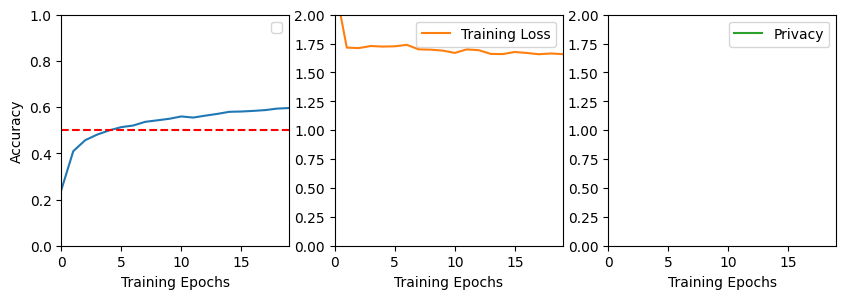

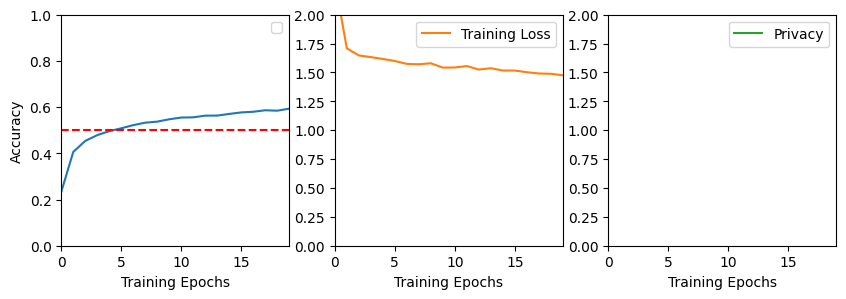

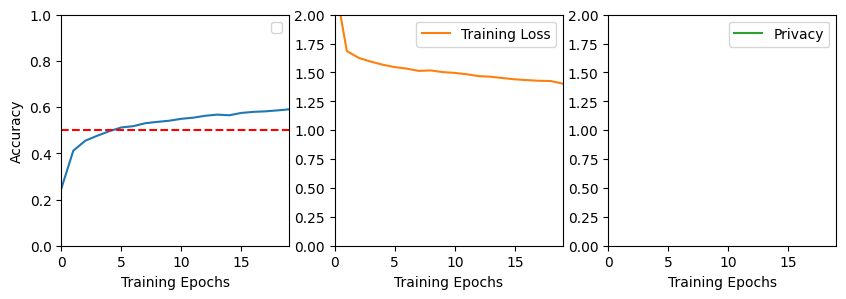

In [ ]:
EPS = 10.0
for c in [1, 5, 10][:]:
    print(f'=====C={c}=====')
    model = load_model()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.RMSprop(model.parameters(), lr=LR)
    privacy_engine = PrivacyEngine()

    model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
        module=model,
        optimizer=optimizer,
        data_loader=train_loader,
        epochs=EPOCHS,
        target_epsilon=EPS,
        target_delta=DELTA,
        max_grad_norm=c,
    )

    cfl_stats = train(model, optimizer, train_loader, EPOCHS, EPS, c, device)
